In [1]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(140)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.3:34999 Dashboard: http://172.30.100.3:35664/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7610413     hsw24 make_pro albert7a PD       0:00      1 (None)
           7610414     hsw24 make_pro albert7a PD       0:00      1 (None)
           7610415     hsw24 make_pro albert7a PD       0:00      1 (None)
           7610416     hsw24 make_pro albert7a PD       0:00      1 (None)
           7610417     hsw24 make_pro albert7a PD       0:00      1 (None)


In [4]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

27


In [5]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           7610413     hsw24 make_pro albert7a  R       0:19      1 n2258
           7610414     hsw24 make_pro albert7a  R       0:19      1 n2401
           7610415     hsw24 make_pro albert7a  R       0:19      1 n2368
           7610416     hsw24 make_pro albert7a  R       0:19      1 n2369
           7610417     hsw24 make_pro albert7a  R       0:19      1 n2370


In [6]:
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [7]:
#params

plot_eke_monthly=False
plot_eke_12_month=True
plot_eke_annual=True


In [8]:
config='EU36'
case='MPC001'
freq='1d'
year='2011'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'+str(year)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'

In [9]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [10]:
def compute_EKE(u,v,u2mean,v2mean):
    ua=0.5*((u2mean-u*u)+(u2mean.shift(x=-1)-u.shift(x=-1)*u.shift(x=-1)))
    va=0.5*((v2mean-v*v)+(v2mean.shift(y=-1)-v.shift(y=-1)*v.shift(y=-1)))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


In [11]:
filesU=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridU.nc'))
filesV=sorted(glob.glob(datadir+'/'+str(config)+'-'+str(case)+'_y'+str(year)+'m??d??.'+str(freq)+'_gridV.nc'))
dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
u=dsU.vozocrtx
v=dsV.vomecrty
mask=dsmask.tmask[0]
u2=u*u
v2=v*v
u2mean=u2.mean(dim='time_counter')
v2mean=v2.mean(dim='time_counter')
eke=compute_EKE(u,v,u2mean,v2mean)


In [12]:
eke

<xarray.DataArray (deptht: 75, y: 1718, x: 732, time_counter: 365)>
dask.array<shape=(75, 1718, 732, 365), dtype=float32, chunksize=(1, 1000, 700, 1)>
Coordinates:
  * deptht         (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(365,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2011-01-01T12:00:00 ... 2011-12-31T12:00:00
Dimensions without coordinates: y, x

In [17]:
eke01=eke.sel(time_counter=slice('2011-01-01','2011-01-31'))

In [18]:
eke01

<xarray.DataArray (deptht: 75, y: 1718, x: 732, time_counter: 31)>
dask.array<shape=(75, 1718, 732, 31), dtype=float32, chunksize=(1, 1000, 700, 1)>
Coordinates:
  * deptht         (deptht) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(31,), chunksize=(1,)>
  * time_counter   (time_counter) datetime64[ns] 2011-01-01T12:00:00 ... 2011-01-31T12:00:00
Dimensions without coordinates: y, x

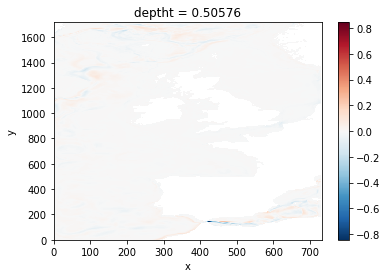

In [19]:
eke01[0].mean(dim='time_counter').plot()